在这个教程中，我想用taxi gps数据计算每一辆出租车在一天内的收入。如果能够成功计算，再看看高收入的出租车司机的行为，就可以分析出来：  
毕业以后要是失业了，怎么样开出租车才能赚更多的钱！升职加薪赢取白富美就在明天！

提供的基础数据是：
<div class="alert alert-info"><h2>提供的基础数据是：</h2><p>   
    数据：<br>  
    1.出租车原始GPS数据<br>  

 </p></div>
 
 <div class="alert alert-info"><h2>深圳出租车计价规则：</h2><p>   
(一)起步价：首2公里11.00元;<br>  
(二)里程价：超过2公里部分，每公里2.40元;<br>  
(三)返空费：每天的23时至次日凌晨6时，超过25公里部分，每公里按上述里程价的30%加收返空费：<br>  
(四)夜间附加费：夜间起步价16元，每天的23时至次日凌晨6时，按上述起步价和里程价的20%加收夜间附加费;<br>  
(五)候时费：每分钟0.80元;<br>  
(六)大件行李费;体积超过0.2立方米、重量超过20公斤的大件行李，每件0.50元。<br>  
 </p></div>  
 
 
在计算的时候，我们可以以订单开始的时间判定夜间还是日间。另外，规则（六）也考虑不了

# 思路
## 首先，我们的输入和输出是什么？

输入很简单，TAXIGPS数据  
输出的形式，应该是：每条订单，收入  
为了后续的分析，在输出的基础上，再增加：订单号，收入，车牌号，订单开始时间，订单结束时间，订单上车坐标，订单下车坐标，行驶里程


那么，从输入怎么变成输出？计算出租车费，我们需要几个东西：订单号，行驶里程，订单开始时间（判断是否为夜间），候时的时长

## 任务分解

搞清楚输入和输出后，应用我们结构化数据的存储及处理的思维方式，就可以进行任务分解了，我们要解决的就是以下几个任务:  

    任务1：由最原始的输入，数据清洗，输出表1，字段与原始数据一致  
    
    任务2：表1输入，整理出每个订单的轨迹，用来计算里程和候时时长，输出表2，字段为：订单号，轨迹点经纬度，轨迹点的时间（订单号这一列需要我们自己定义）,速度（用来计算候时时长）  
    
    任务3：表2输入，计算每个订单的里程和候时时长，输出表3，字段为：订单号，订单的里程，候时时长  
    
    任务4：表1输入，整理出每个订单的其他信息，输出表4，字段为：订单号，车牌号，订单开始时间，订单结束时间，订单上车坐标，订单下车坐标  
    
    任务5：表3与表4输入，连接两个表，再计算订单收入，输出表5，字段为：订单号，收入，车牌号，订单开始时间，订单结束时间，订单上车坐标，订单下车坐标，行驶里程

# 数据

In [2]:
import pandas as pd

In [10]:

#读取数据
data2 = pd.read_csv(r'data-sample/TaxiData-Sample',header = None)
#给数据命名列
data2.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']
data2.head(5)

,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed
0,22271,22:54:04,114.167000,22.718399,0,0
1,22271,18:26:26,114.190598,22.647800,0,4
2,22271,18:35:18,114.201401,22.649700,0,0
3,22271,16:02:46,114.233498,22.725901,0,24
4,22271,21:41:17,114.233597,22.720900,0,19


# 订单收入计算

## 数据清洗

In [11]:
data2=data2.sort_values(by=['VehicleNum','Stime'])
#第一节课教的
data2 = data2[-((data2['OpenStatus'].shift(1)== data2['OpenStatus'].shift(-1))&\
      (data2['OpenStatus'].shift(1)!= data2['OpenStatus'])&\
      (data2['VehicleNum'].shift(1)==data2['VehicleNum'].shift(-1))&\
      (data2['VehicleNum']==data2['VehicleNum'].shift(1)))]
len(data2)

1598866

In [12]:
#将时间字符串转换为pd的时间格式，后面可以轻松的做加减
data2['Stime'] = pd.to_datetime(data2['Stime'])

## 订单号生成

如果StatusChange为这一条数据的OpenStatus减去上一条数据的OpenStatus，这样就会出现：

|OpenStatus     |   OpenStatus1    |  StatusChange||
| ----------- |-----------|||
|0          |       0    |             0||
|0          |       0    |             0||
|0         |        0    |             0||
|0          |       0    |             0 |    ←此时乘客上车了|
|1          |       0    |             1  |   ←此时乘客上车了|
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0|    ←此时乘客下车了|
|0          |       1    |             -1  |  ←此时乘客下车了|
|0          |       0    |             0||
|0          |       0    |             0||
|0          |       0    |             0||


那么如果我只把所有OpenStatus==1的数据拿出来，就会有：


|OpenStatus     |   orderid(订单号：对StatusChange的累加，可以用pandas的.cumsum()功能)    |  StatusChange||
| ----------- |-----------|||
|1          |       0    |             0||
|1          |       0    |             0||
|1         |        0    |             0||
|1          |       0    |             0 ||
|1          |       1    |             1  |   ←新订单|
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       1    |             0||
|1          |       2   |             1  |  ←新订单|
|1          |       2    |             0||
|1          |       2    |             0||
|1          |       2    |             0||


In [13]:
data2['OpenStatus1'] = data2['OpenStatus'].shift()
data2['VehicleNum1'] = data2['VehicleNum'].shift()

data2['Lng1'] = data2['Lng'].shift()
data2['Lat1'] = data2['Lat'].shift()
data2['Stime1'] = data2['Stime'].shift()

data2['StatusChange'] = data2['OpenStatus1']-data2['OpenStatus']
data2 = data2[data2['OpenStatus1']==1]
data2['orderid'] = data2['StatusChange'].cumsum()
data2.head(30)

,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed,OpenStatus1,VehicleNum1,Lng1,Lat1,Stime1,StatusChange,orderid
1548741,22334,2020-01-20 00:00:52,114.111130,22.576750,1,13,1.0,22334.0,114.111847,22.576633,2020-01-20 00:00:32,0.0,0.0
1550370,22334,2020-01-20 00:01:04,114.111130,22.576750,0,0,1.0,22334.0,114.111130,22.576750,2020-01-20 00:00:52,1.0,1.0
1549616,22334,2020-01-20 00:08:17,114.080551,22.554251,1,0,1.0,22334.0,114.080498,22.554182,2020-01-20 00:07:57,0.0,1.0
1549617,22334,2020-01-20 00:08:37,114.080551,22.554251,1,0,1.0,22334.0,114.080551,22.554251,2020-01-20 00:08:17,0.0,1.0
1547008,22334,2020-01-20 00:08:57,114.080551,22.554251,1,0,1.0,22334.0,114.080551,22.554251,2020-01-20 00:08:37,0.0,1.0
1548874,22334,2020-01-20 00:09:17,114.081131,22.552799,1,15,1.0,22334.0,114.080551,22.554251,2020-01-20 00:08:57,0.0,1.0
1550335,22334,2020-01-20 00:09:37,114.080681,22.551718,1,30,1.0,22334.0,114.081131,22.552799,2020-01-20 00:09:17,0.0,1.0
1547678,22334,2020-01-20 00:09:57,114.078049,22.551600,1,50,1.0,22334.0,114.080681,22.551718,2020-01-20 00:09:37,0.0,1.0
1549818,22334,2020-01-20 00:10:17,114.076401,22.551550,1,30,1.0,22334.0,114.078049,22.551600,2020-01-20 00:09:57,0.0,1.0
1548021,22334,2020-01-20 00:10:37,114.076401,22.551550,1,0,1.0,22334.0,114.076401,22.551550,2020-01-20 00:10:17,0.0,1.0


In [14]:
#表2入手
table2 = data2[['orderid','Lng','Lat','Stime','Speed']]
table2.head(5)

,orderid,Lng,Lat,Stime,Speed
1548741,0.0,114.111130,22.576750,2020-01-20 00:00:52,13
1550370,1.0,114.111130,22.576750,2020-01-20 00:01:04,0
1549616,1.0,114.080551,22.554251,2020-01-20 00:08:17,0
1549617,1.0,114.080551,22.554251,2020-01-20 00:08:37,0
1547008,1.0,114.080551,22.554251,2020-01-20 00:08:57,0


## 订单里程计算与候车时间

In [39]:
#表2
#计算里程

#定义计算路径长度函数

from math import pi
import numpy as np

def getdistance(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）输入为DataFrame的列
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(lambda r:r*pi/180, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(a**0.5) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000




In [41]:
#生成订单的里程

table3 = table2.copy()
table3['Lng1'] = table3['Lng'].shift(-1)
table3['Lat1'] = table3['Lat'].shift(-1)
table3['orderid1'] = table3['orderid'].shift(-1)
table3['Stime1'] = table3['Stime'].shift(-1)

table3 = table3[(table3['orderid1'] == table3['orderid'])]
#计算每个点与下一个点的距离
lon1 = table3['Lng']
lat1 = table3['Lat']
lon2 = table3['Lng1']
lat2 = table3['Lat1']
table3['distance'] = getdistance(lon1, lat1, lon2, lat2)


#计算每个点与下一个点的时间差
table3['interval'] = (table3['Stime1']-table3['Stime']).apply(lambda r:r.seconds)

#集计得到出租车路径长度
orderlenth = table3[['orderid','distance']].groupby('orderid').sum().reset_index()

waittime = table3[table3['distance']==0][['orderid','interval']].groupby('orderid').sum()


table3 = pd.merge(orderlenth,waittime,on = 'orderid',how='left')
table3.head(10)

,orderid,distance,interval
0,1.0,6785.602632,180.0
1,2.0,15698.063306,309.0
2,3.0,12508.941904,140.0
3,4.0,15144.760499,100.0
4,5.0,15458.541238,60.0
5,6.0,3797.074876,80.0
6,7.0,7497.547127,40.0
7,8.0,4287.367646,60.0
8,9.0,5056.517539,300.0
9,10.0,2732.022522,200.0


## 生成表4

In [75]:
#表4的字段
#订单号，车牌号，订单开始时间，订单结束时间，订单上车坐标，订单下车坐标  

In [45]:
#将每一个出行的起点与终点提取出来
o = data2.iloc[:1].append(data2[data2['StatusChange']==1])
d = data2[(data2['StatusChange']==1).shift(-1).fillna(False)]
table4 = o.append(d).sort_values(by = ['orderid','Stime'])[['orderid','VehicleNum','Stime','Lng','Lat']]
table4.head(5)

,orderid,VehicleNum,Stime,Lng,Lat
1548741,0.0,22334,2020-01-20 00:00:52,114.111130,22.57675
1548741,0.0,22334,2020-01-20 00:00:52,114.111130,22.57675
1550370,1.0,22334,2020-01-20 00:01:04,114.111130,22.57675
1549620,1.0,22334,2020-01-20 00:17:58,114.084915,22.54085
1550727,2.0,22334,2020-01-20 00:18:16,114.084915,22.54085


In [46]:
#加一列isd，如果该行为起点，则isd=0，如果该行为终点，则isd=1
table4['isd'] = [i%2 for i in range(len(table4))]
table4.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd
1548741,0.0,22334,2020-01-20 00:00:52,114.111130,22.57675,0
1548741,0.0,22334,2020-01-20 00:00:52,114.111130,22.57675,1
1550370,1.0,22334,2020-01-20 00:01:04,114.111130,22.57675,0
1549620,1.0,22334,2020-01-20 00:17:58,114.084915,22.54085,1
1550727,2.0,22334,2020-01-20 00:18:16,114.084915,22.54085,0


In [49]:
# 把O与D的信息放在同一行
table4['Etime'] = table4['Stime'].shift(-1)
table4['ELng'] = table4['Lng'].shift(-1)
table4['ELat'] = table4['Lat'].shift(-1)
table4 = table4[(table4['isd']==0)&(-table4['Etime'].isnull())]

In [54]:
#连接表3与表4成为表5
table5 = pd.merge(table4,table3,on = 'orderid',how = 'left')
table5.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,interval
0,0.0,22334,2020-01-20 00:00:52,114.111130,22.576750,0,2020-01-20 00:00:52,114.111130,22.576750,NaN,NaN
1,1.0,22334,2020-01-20 00:01:04,114.111130,22.576750,0,2020-01-20 00:17:58,114.084915,22.540850,6785.602632,180.0
2,2.0,22334,2020-01-20 00:18:16,114.084915,22.540850,0,2020-01-20 00:44:47,114.056236,22.633383,15698.063306,309.0
3,3.0,22334,2020-01-20 00:44:52,114.056236,22.633383,0,2020-01-20 02:46:52,114.093498,22.554382,12508.941904,140.0
4,4.0,22334,2020-01-20 02:47:04,114.093536,22.554382,0,2020-01-20 04:13:57,114.052299,22.604366,15144.760499,100.0


In [57]:
#每天的23时至次日凌晨6时为夜间
table5['isnight'] = (table5['Stime'].apply(lambda r:r.hour)<6)|(table5['Stime'].apply(lambda r:r.hour)>=23)
table5.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,interval,isnight
0,0.0,22334,2020-01-20 00:00:52,114.111130,22.576750,0,2020-01-20 00:00:52,114.111130,22.576750,NaN,NaN,True
1,1.0,22334,2020-01-20 00:01:04,114.111130,22.576750,0,2020-01-20 00:17:58,114.084915,22.540850,6785.602632,180.0,True
2,2.0,22334,2020-01-20 00:18:16,114.084915,22.540850,0,2020-01-20 00:44:47,114.056236,22.633383,15698.063306,309.0,True
3,3.0,22334,2020-01-20 00:44:52,114.056236,22.633383,0,2020-01-20 02:46:52,114.093498,22.554382,12508.941904,140.0,True
4,4.0,22334,2020-01-20 02:47:04,114.093536,22.554382,0,2020-01-20 04:13:57,114.052299,22.604366,15144.760499,100.0,True


## 收入计算

(一)起步价：首2公里11.00元;  
(二)里程价：超过2公里部分，每公里2.40元;  
(三)返空费：每天的23时至次日凌晨6时，超过25公里部分，每公里按上述里程价的30%加收返空费：  
(四)夜间附加费：夜间起步价16元，每天的23时至次日凌晨6时，按上述起步价和里程价的20%加收夜间附加费;  
(五)候时费：每分钟0.80元;  

In [63]:
#起步价
table5['起步价'] = table5['isnight']*(16-11)+11

In [64]:
#里程价
table5['里程价'] = ((table5['distance']-2000)>0)*(table5['distance']-2000)*2.4/1000

In [65]:
#返空费
table5['返空费'] = table5['isnight']*((table5['distance']-25000)>0)*((table5['distance']-25000)*2.4*0.3/1000)

In [66]:
#夜间附加费(里程价)
table5['夜间附加费'] = table5['isnight']*((table5['distance']-2000)>0)*(table5['distance']-2000)*2.4*0.2/1000

In [67]:
#候时费
table5['候时费'] = table5['interval']/60*0.8

In [68]:
#最终价格
table5['price'] = table5['起步价'] + table5['里程价'] + table5['返空费'] + table5['夜间附加费'] + table5['候时费']
table5.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,interval,isnight,起步价,里程价,返空费,夜间附加费,候时费,price
0,0.0,22334,2020-01-20 00:00:52,114.111130,22.576750,0,2020-01-20 00:00:52,114.111130,22.576750,NaN,NaN,True,16,NaN,NaN,NaN,NaN,NaN
1,1.0,22334,2020-01-20 00:01:04,114.111130,22.576750,0,2020-01-20 00:17:58,114.084915,22.540850,6785.602632,180.0,True,16,11.485446,-0.0,2.297089,2.400000,32.182536
2,2.0,22334,2020-01-20 00:18:16,114.084915,22.540850,0,2020-01-20 00:44:47,114.056236,22.633383,15698.063306,309.0,True,16,32.875352,-0.0,6.575070,4.120000,59.570422
3,3.0,22334,2020-01-20 00:44:52,114.056236,22.633383,0,2020-01-20 02:46:52,114.093498,22.554382,12508.941904,140.0,True,16,25.221461,-0.0,5.044292,1.866667,48.132419
4,4.0,22334,2020-01-20 02:47:04,114.093536,22.554382,0,2020-01-20 04:13:57,114.052299,22.604366,15144.760499,100.0,True,16,31.547425,-0.0,6.309485,1.333333,55.190244


In [69]:
#筛选掉没有计算出来价格的数据
table5 = table5[-table5['price'].isnull()]
table5.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,interval,isnight,起步价,里程价,返空费,夜间附加费,候时费,price
1,1.0,22334,2020-01-20 00:01:04,114.111130,22.576750,0,2020-01-20 00:17:58,114.084915,22.540850,6785.602632,180.0,True,16,11.485446,-0.0,2.297089,2.400000,32.182536
2,2.0,22334,2020-01-20 00:18:16,114.084915,22.540850,0,2020-01-20 00:44:47,114.056236,22.633383,15698.063306,309.0,True,16,32.875352,-0.0,6.575070,4.120000,59.570422
3,3.0,22334,2020-01-20 00:44:52,114.056236,22.633383,0,2020-01-20 02:46:52,114.093498,22.554382,12508.941904,140.0,True,16,25.221461,-0.0,5.044292,1.866667,48.132419
4,4.0,22334,2020-01-20 02:47:04,114.093536,22.554382,0,2020-01-20 04:13:57,114.052299,22.604366,15144.760499,100.0,True,16,31.547425,-0.0,6.309485,1.333333,55.190244
5,5.0,22334,2020-01-20 04:23:07,114.052216,22.602118,0,2020-01-20 06:41:19,114.067886,22.521299,15458.541238,60.0,True,16,32.300499,-0.0,6.460100,0.800000,55.560599


In [70]:
#保存
table5.to_csv(r'data-sample/taxi-price.csv',index = None)

# 如何做一个优雅的出租车手？

In [3]:
table5 = pd.read_csv(r'data-sample/taxi-price.csv')
table5.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,interval,isnight,起步价,里程价,返空费,夜间附加费,候时费,price
0,1.0,22334,2020-01-20 00:01:04,114.111130,22.576750,0,2020-01-20 00:17:58,114.084915,22.540850,6785.602632,180.0,True,16,11.485446,-0.0,2.297089,2.400000,32.182536
1,2.0,22334,2020-01-20 00:18:16,114.084915,22.540850,0,2020-01-20 00:44:47,114.056236,22.633383,15698.063306,309.0,True,16,32.875352,-0.0,6.575070,4.120000,59.570422
2,3.0,22334,2020-01-20 00:44:52,114.056236,22.633383,0,2020-01-20 02:46:52,114.093498,22.554382,12508.941904,140.0,True,16,25.221461,-0.0,5.044292,1.866667,48.132419
3,4.0,22334,2020-01-20 02:47:04,114.093536,22.554382,0,2020-01-20 04:13:57,114.052299,22.604366,15144.760499,100.0,True,16,31.547425,-0.0,6.309485,1.333333,55.190244
4,5.0,22334,2020-01-20 04:23:07,114.052216,22.602118,0,2020-01-20 06:41:19,114.067886,22.521299,15458.541238,60.0,True,16,32.300499,-0.0,6.460100,0.800000,55.560599


做一些预处理操作，剔除不合理数据

In [4]:
#计算订单用时
table5['interval'] = (pd.to_datetime(table5['Etime']) -pd.to_datetime(table5['Stime'])).apply(lambda r:r.seconds)
#运营车速
table5['speed'] = (table5['distance']/table5['interval'])*3.6
#运营车速太快的筛掉
table5 = table5[table5['speed']<80].copy()
#每分钟平均收入多少
table5['price_per_minutes'] = table5['price']/(table5['interval']/60)

In [5]:
len(table5)

10592

## 出租车一天收入多少

In [6]:
#集计收入
df0 = table5.groupby('VehicleNum')['price'].sum()

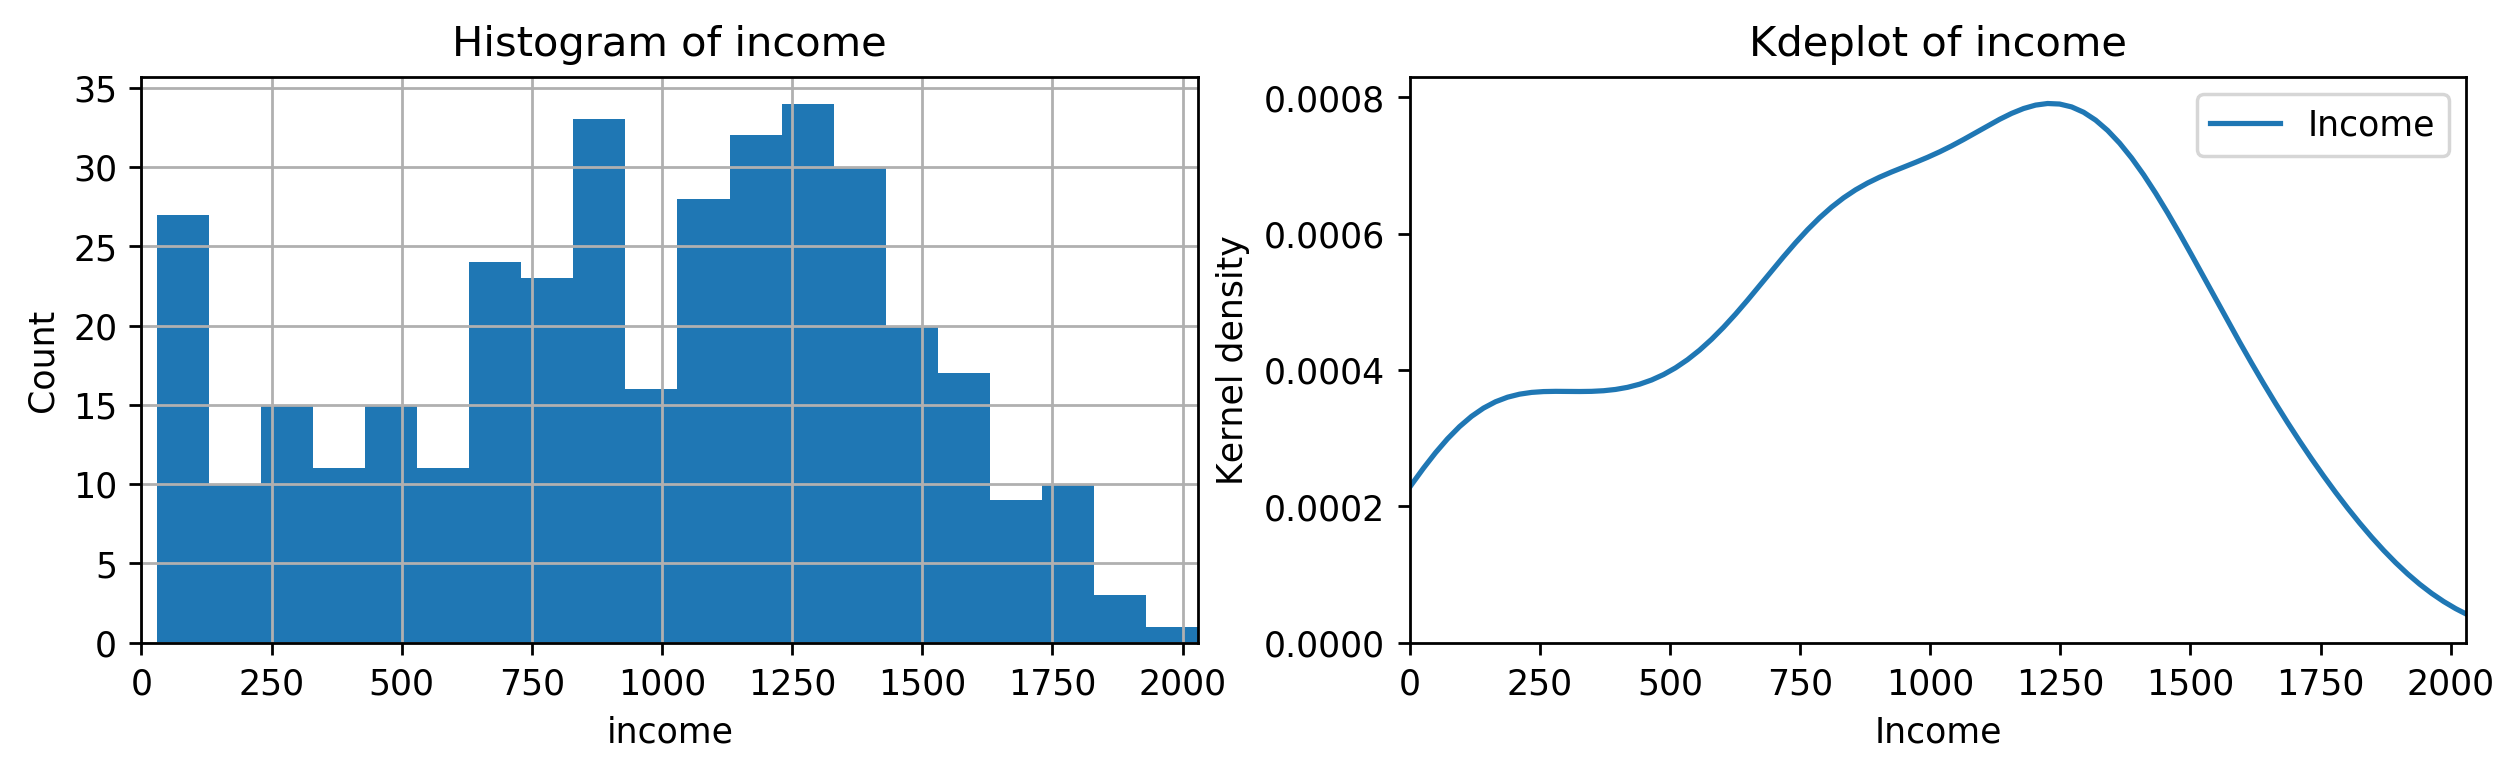

In [8]:
#用pandas自带hist绘制直方图
import matplotlib.pyplot as plt
fig     = plt.figure(1,(12,3),dpi = 250)    
ax1      = plt.subplot(121)
plt.sca(ax1)
df0.hist(ax = ax1,bins = 20)
plt.ylabel('Count')
plt.xlabel('income')
plt.xlim(0,df0.quantile(1))
plt.title('Histogram of income')

import seaborn as sns
#用seaborn绘制kdeplot核密度分布
ax2      = plt.subplot(122)
plt.sca(ax2)
sns.kdeplot(df0,ax = ax2,label = 'Income')
plt.ylabel('Kernel density')
plt.xlabel('Income')
plt.xlim(0,df0.quantile(1))
plt.title('Kdeplot of income')
plt.show()

## 去哪接客挣钱多？

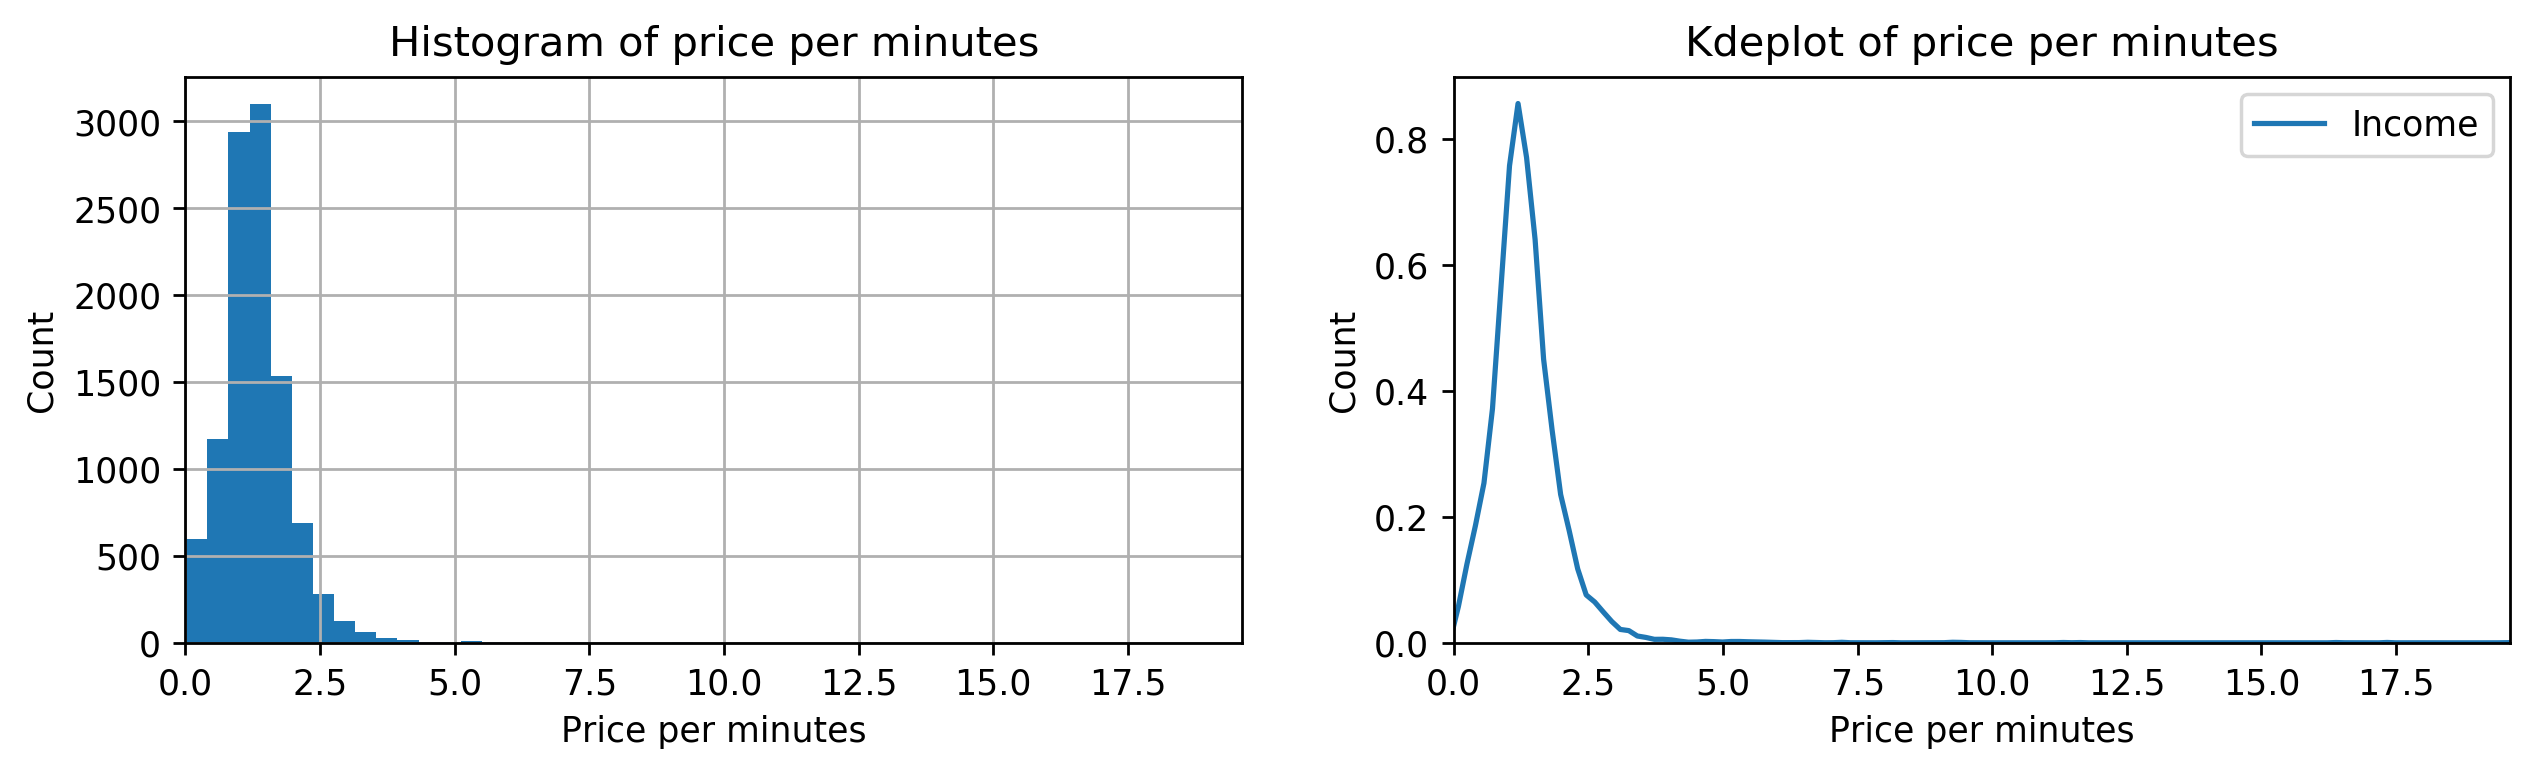

In [9]:

#用pandas自带hist绘制直方图
import matplotlib.pyplot as plt
fig     = plt.figure(1,(12,3),dpi = 250)    
ax1      = plt.subplot(121)
plt.sca(ax1)
table5['price_per_minutes'].hist(ax = ax1,bins = 50)
plt.ylabel('Count')
plt.xlabel('Price per minutes')
plt.title('Histogram of price per minutes')
plt.xlim(0,table5['price_per_minutes'].max())

import seaborn as sns
#用seaborn绘制kdeplot核密度分布
ax2      = plt.subplot(122)
plt.sca(ax2)
sns.kdeplot(table5['price_per_minutes'],ax = ax2,label = 'Income')
plt.ylabel('Count')
plt.xlabel('Price per minutes')

plt.xlim(0,table5['price_per_minutes'].quantile(1))
plt.title('Kdeplot of price per minutes')
plt.show()

绘制一下热力图，看看在出租车订单起点处平均价格的空间分布

In [10]:
#栅格数据
#读取shapefile文件
import geopandas
shp = r'shapefile/grid/grid.shp'
grid = geopandas.GeoDataFrame.from_file(shp,encoding = 'gbk')


In [11]:
#计算每个格子的平均收入
data = table5[['Lng','Lat','price_per_minutes']].copy()


#经纬度小数点保留三位小数
import math
#划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#定义栅格大小(单位m)
accuracy = 500;

#计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

data['LONCOL'] = ((data['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
data['LATCOL'] = ((data['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')

data = data.groupby(['LONCOL','LATCOL'])['price_per_minutes'].mean().reset_index()

data.head(5)

,LONCOL,LATCOL,price_per_minutes
0,6,52,0.782425
1,8,52,2.444964
2,8,54,3.461804
3,8,57,1.895827
4,8,80,1.105671


In [12]:
#将集计的结果与栅格的geopandas执行merge操作
gridtoplot = pd.merge(grid,data,on = ['LONCOL','LATCOL'])
gridtoplot.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry,price_per_minutes
0,6,52,113.778739,22.679412,"POLYGON ((113.77630 22.67716, 113.77630 22.681...",0.782425
1,8,52,113.788485,22.679412,"POLYGON ((113.78605 22.67716, 113.78605 22.681...",2.444964
2,8,54,113.788485,22.688405,"POLYGON ((113.78605 22.68616, 113.78605 22.690...",3.461804
3,8,57,113.788485,22.701895,"POLYGON ((113.78605 22.69965, 113.78605 22.704...",1.895827
4,9,52,113.793357,22.679412,"POLYGON ((113.79092 22.67716, 113.79092 22.681...",0.450346


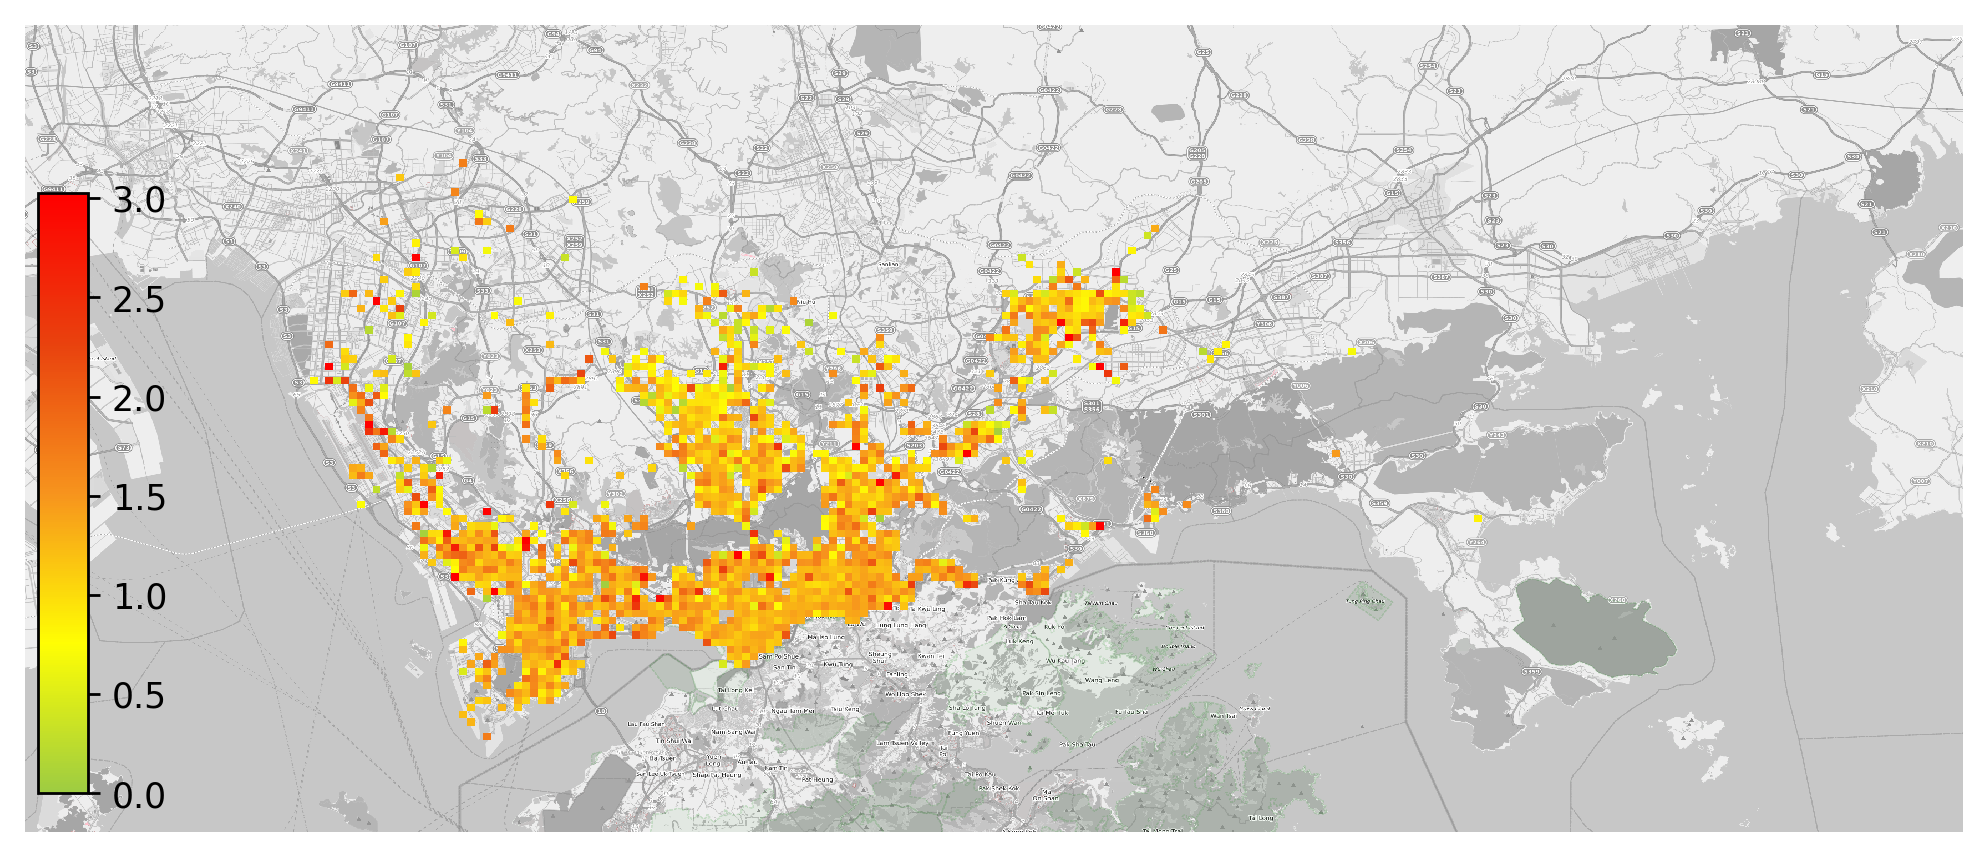

In [13]:
#绘制地理分布图
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

bounds = [113.6,22.4,114.8,22.9]
#绘制地图
import plot_map
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#设置colormap的数据
import matplotlib
vmax = gridtoplot['price_per_minutes'].quantile(0.99)
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = matplotlib.colors.Normalize(vmin=0,vmax=vmax)

#设定colormap的颜色
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)



#将gridtoplot这个geodataframe进行绘制
#提示：用gridtoplot.plot，设定里面的参数是column = 'count'，以count这一列来绘制。参数cmap = cmap设定它的颜色
gridtoplot.plot(ax = ax,column = 'price_per_minutes',cmap = cmap,vmax = vmax,vmin = 0)


#不显示坐标轴
plt.axis('off')    

#绘制colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)

#然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了


ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()

## 什么时候接客订单多？什么时候接客单笔订单价格高？

In [14]:
table5['Shour'] = pd.to_datetime(table5['Stime']).apply(lambda r:r.hour)

In [15]:
# 每小时订单数
df1 = table5.groupby(['Shour'])['VehicleNum'].count().reset_index()
# 每小时平均订单价格
df2 = table5.groupby(['Shour'])['price_per_minutes'].mean().reset_index()


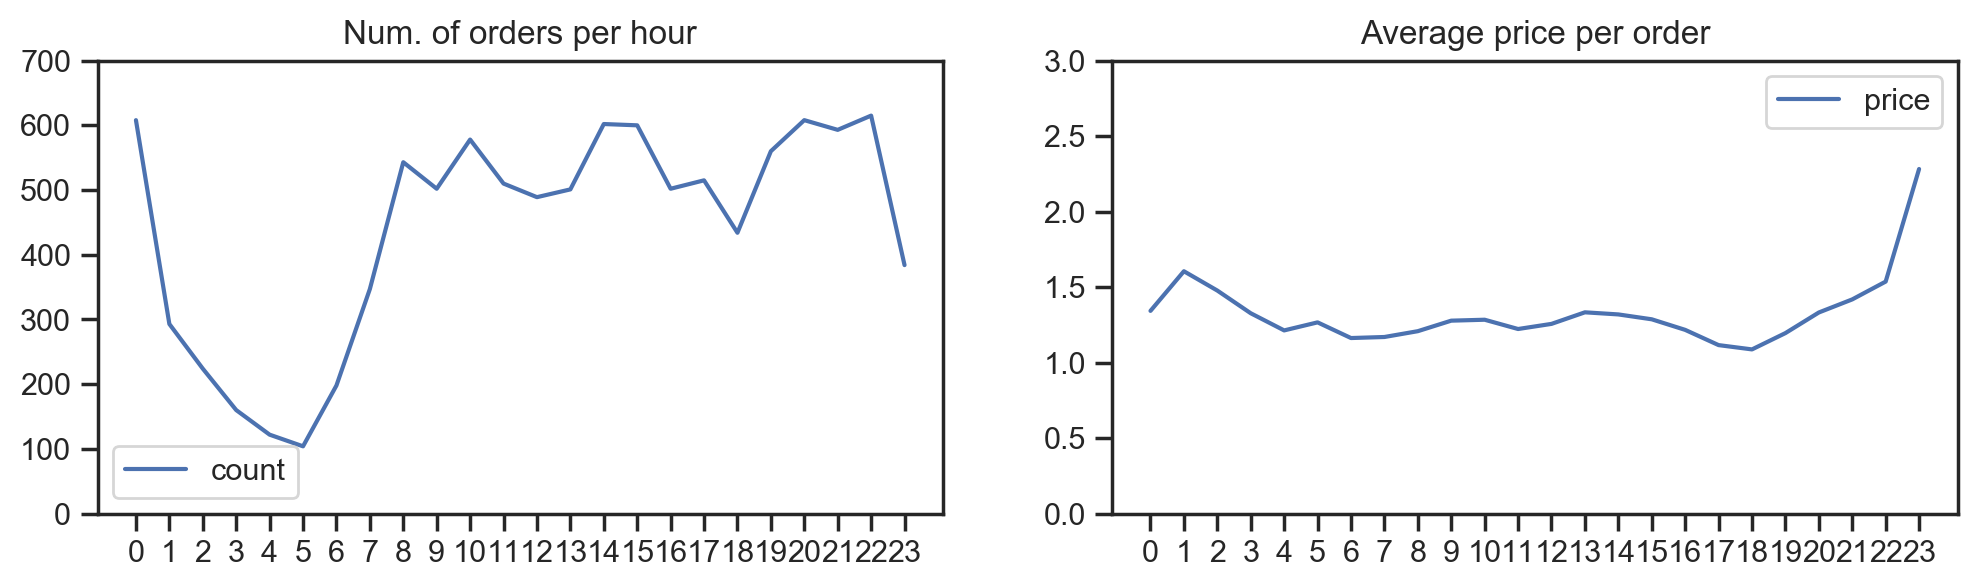

In [64]:
fig     = plt.figure(1,(12,3),dpi = 200)    

#创建一个子图
ax1      = plt.subplot(121)
plt.sca(ax1)

#绘制折线图
plt.plot(df1['Shour'],df1['VehicleNum'],label = 'count')
plt.legend()
plt.title('Num. of orders per hour')
plt.xticks(range(24),df1['Shour'])
plt.ylim(0,700)
#创建另一个子图
ax2      = plt.subplot(122)
plt.sca(ax2)

#绘制折线图
plt.plot(df1['Shour'],df2['price_per_minutes'],label = 'price')
plt.legend()
plt.title('Average price per order')
plt.xticks(range(24),df1['Shour'])
plt.ylim(0,3)
plt.show()

## 收入最高的车手与收入中等的车手，挣钱方式有什么不一样吗

抽取高收入车手（收入排名前20%），中等收入车手（收入排名40%-60%）

In [17]:
highincome = df0[df0>df0.quantile(0.8)].reset_index()['VehicleNum']
len(highincome)

74

In [18]:
midincome = df0[(df0>df0.quantile(0.4))&(df0<df0.quantile(0.6))].reset_index()['VehicleNum']
len(midincome)

73

In [19]:
#提取两组车手的订单
highincome_order = pd.merge(table5,highincome,on = 'VehicleNum')
midincome_order = pd.merge(table5,midincome,on = 'VehicleNum')

In [20]:
highincome_order.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,...,isnight,起步价,里程价,返空费,夜间附加费,候时费,price,speed,price_per_minutes,Shour
0,133.0,22455,2020-01-20 00:00:02,113.909340,22.485928,0,2020-01-20 00:57:56,114.098518,22.579077,33896.340821,...,True,16,76.551218,6.405365,15.310244,1.906667,116.173494,35.125742,2.006451,0
1,135.0,22455,2020-01-20 01:36:34,114.165077,22.564360,0,2020-01-20 01:49:19,114.122047,22.569462,8909.947881,...,True,16,16.583875,-0.000000,3.316775,0.133333,36.033983,41.929166,2.826195,1
2,136.0,22455,2020-01-20 01:49:34,114.121758,22.569315,0,2020-01-20 02:25:27,114.124191,22.552382,11206.099299,...,True,16,22.094638,-0.000000,4.418928,0.586667,43.100233,18.737556,1.201121,1
3,137.0,22455,2020-01-20 02:25:34,114.124168,22.552378,0,2020-01-20 02:41:45,114.064377,22.531965,6973.034435,...,True,16,11.935283,-0.000000,2.387057,0.386667,30.709006,25.852651,1.897570,2
4,139.0,22455,2020-01-20 02:49:34,114.042885,22.527573,0,2020-01-20 04:00:05,114.039429,22.560907,19407.948504,...,True,16,41.779076,-0.000000,8.355815,1.013333,67.148225,16.513499,0.952232,2


观察高收入中收入群体每天的订单数量，与订单每分钟收入分布情况

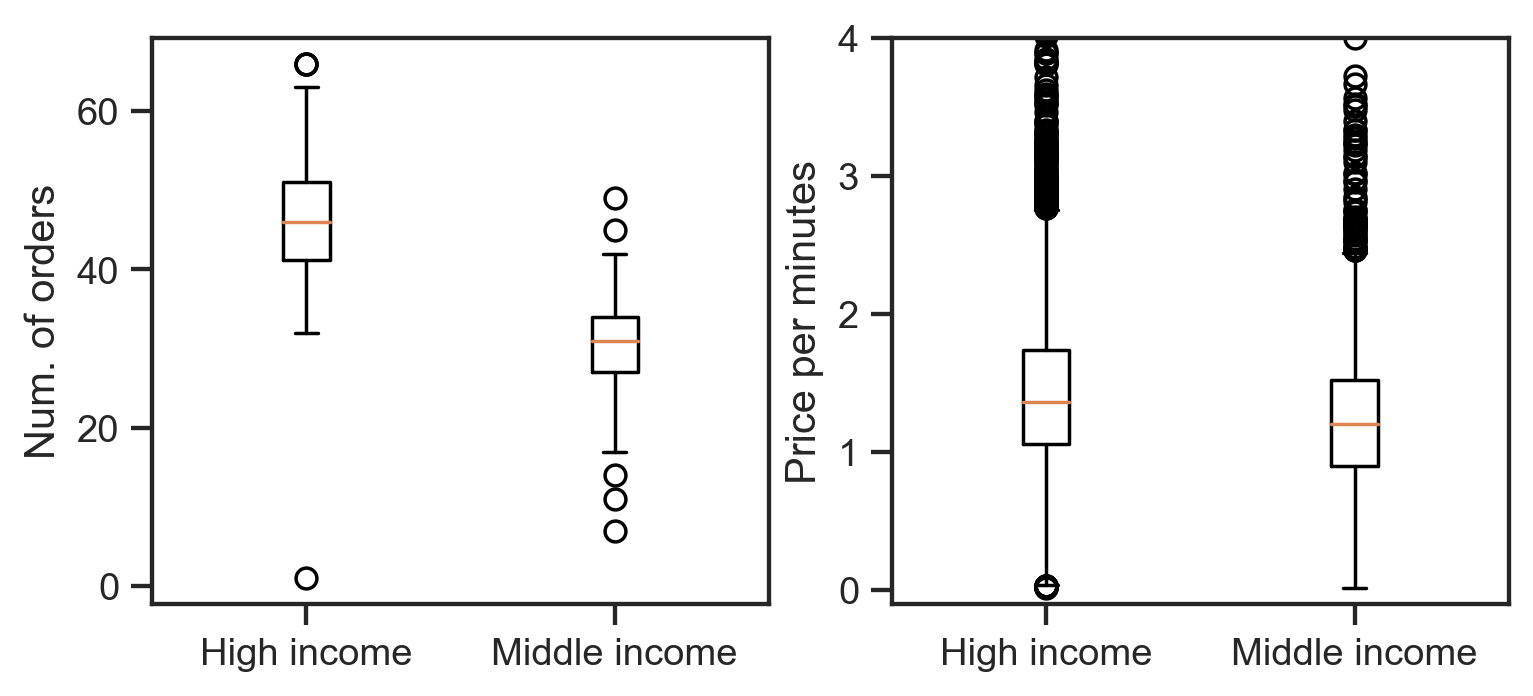

In [40]:
#高收入中收入群体每天的订单数量
fig     = plt.figure(1,(7,3),dpi = 250)    
ax      = plt.subplot(121)
plt.sca(ax)
plt.boxplot([highincome_order.groupby('VehicleNum')['orderid'].count(),
midincome_order.groupby('VehicleNum')['orderid'].count()])
plt.xticks([1,2],['High income','Middle income'])
plt.ylabel('Num. of orders')


#订单每分钟收入分布情况
  
ax      = plt.subplot(122)
plt.sca(ax)
plt.boxplot([highincome_order['price_per_minutes'],
midincome_order['price_per_minutes']])
plt.xticks([1,2],['High income','Middle income'])
plt.ylim(-0.1,4)
plt.ylabel('Price per minutes')
plt.show()


上左图可以看到，高收入车手每日接单数量说比中收入车手多的，也就是，高收入主要靠勤奋  
上右图可看到，高收入车手的订单的每分钟平均收入要稍微比中收入车手高  
也就是说，高收入车手靠的不仅仅是勤奋  
那么，高收入车手接的单为什么会稍微贵一点呢？猜想可能的原因有两种  

>1.高收入车手每天非常勤奋，半夜也出来接单，这样就比较贵  
2.高收入车手存在拒载，或者只在特定地方接单，避免接到便宜的单  


## 具体一点，到底在哪里存在差距？

### 高收入者比中收入者勤奋吗

高收入群体和中收入群体开车总路程

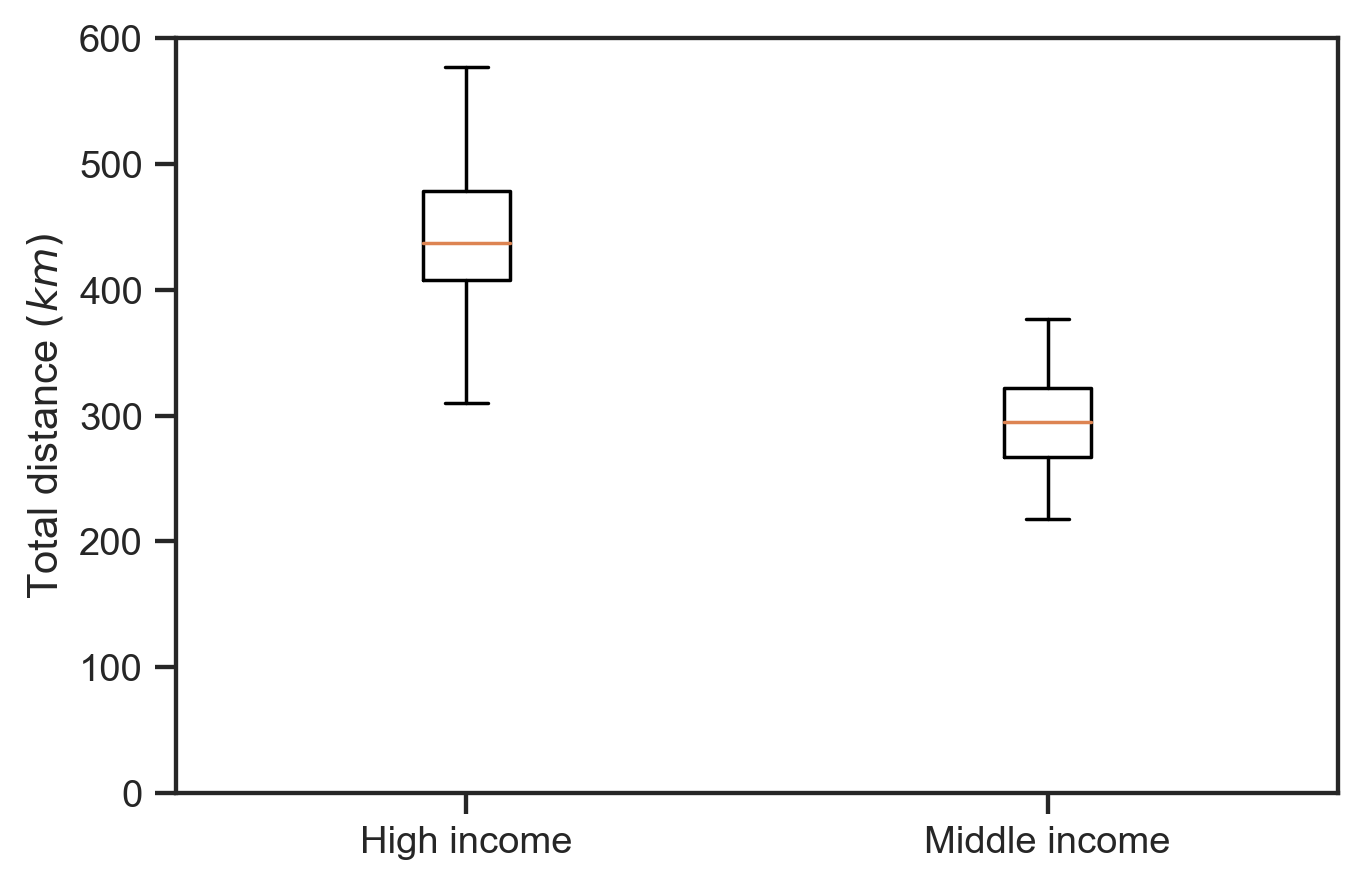

In [87]:
#统计高收入者和中收入者每天行驶总路程
high=  highincome_order.groupby('VehicleNum')['distance'].sum()/1000
mid=  midincome_order.groupby('VehicleNum')['distance'].sum()/1000
#高收入中收入群体每天的订单数量
fig     = plt.figure(1,(6,4),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
plt.boxplot([high,
mid])
plt.xticks([1,2],['High income','Middle income'])
plt.ylabel('Total distance $(km)$')
plt.ylim(0,600)
plt.show()

In [88]:
high.mean()/mid.mean()

1.506497067276359

是的,高收入者比中等收入者勤奋1.5倍

### 高收入者比中收入者开车更有技巧吗

我们观察一下每小时高收入群体和中等收入群体的订单收入情况  
将高收入和中等收入的订单打上标签，合并一起，后面可以用seaborn绘制分组的boxplot

In [47]:

high_hour =  highincome_order[['Stime','price_per_minutes']].copy()
high_hour['Shour'] = pd.to_datetime(highincome_order['Stime']).apply(lambda r:r.hour)
high_hour['Index'] = 'High income'
mid_hour =  midincome_order[['Stime','price_per_minutes']].copy()
mid_hour['Shour'] = pd.to_datetime(midincome_order['Stime']).apply(lambda r:r.hour)
mid_hour['Index'] = 'Middle income'
hourdata = pd.concat([high_hour,mid_hour])

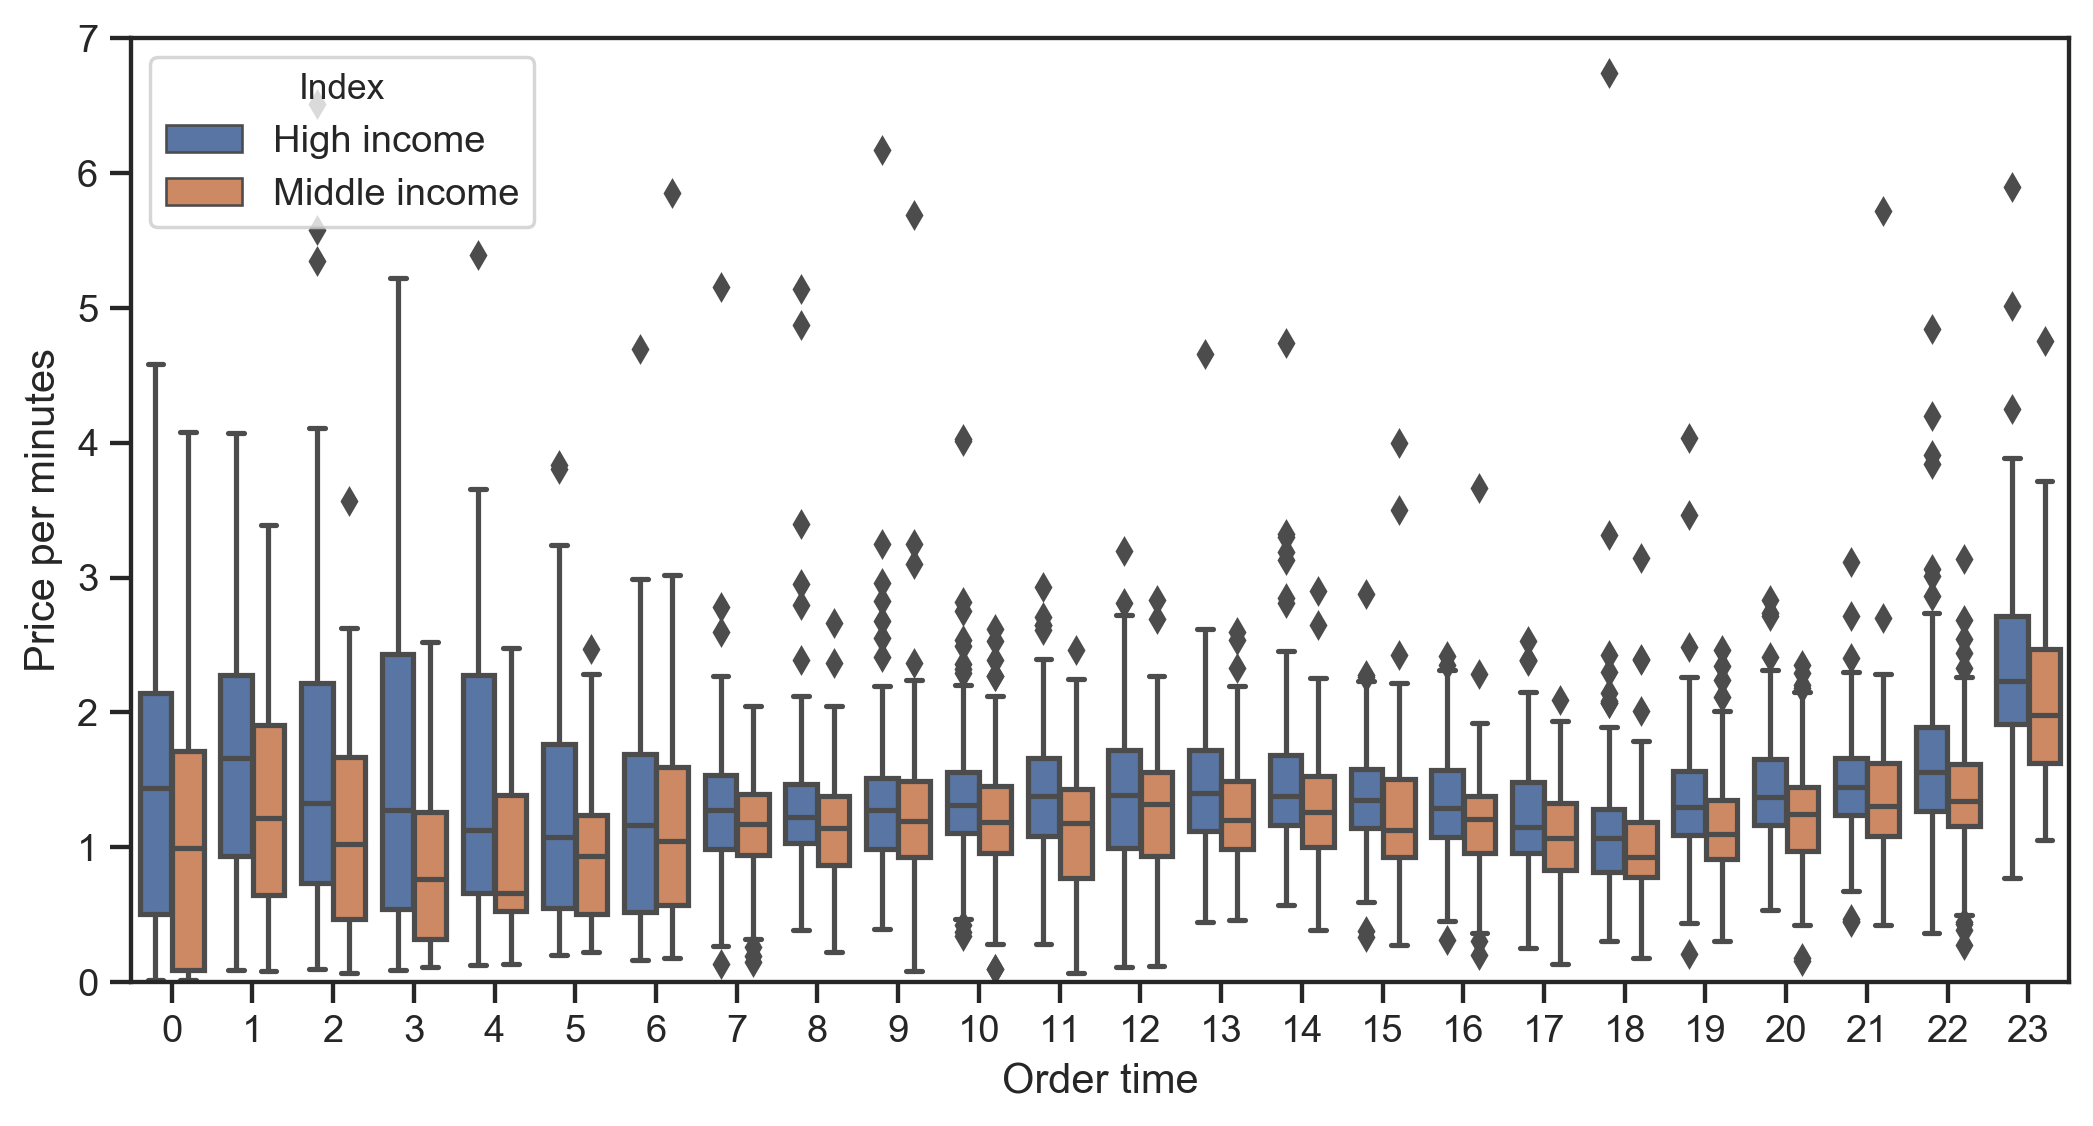

In [53]:

#绘图
fig     = plt.figure(1,(10,5),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="Shour", y="price_per_minutes",hue="Index", data=hourdata,ax = ax)
plt.ylabel('Price per minutes')
plt.xlabel('Order time')
plt.ylim(0,7)
plt.show()

统计高收入者和低收入者每小时平均的订单数量

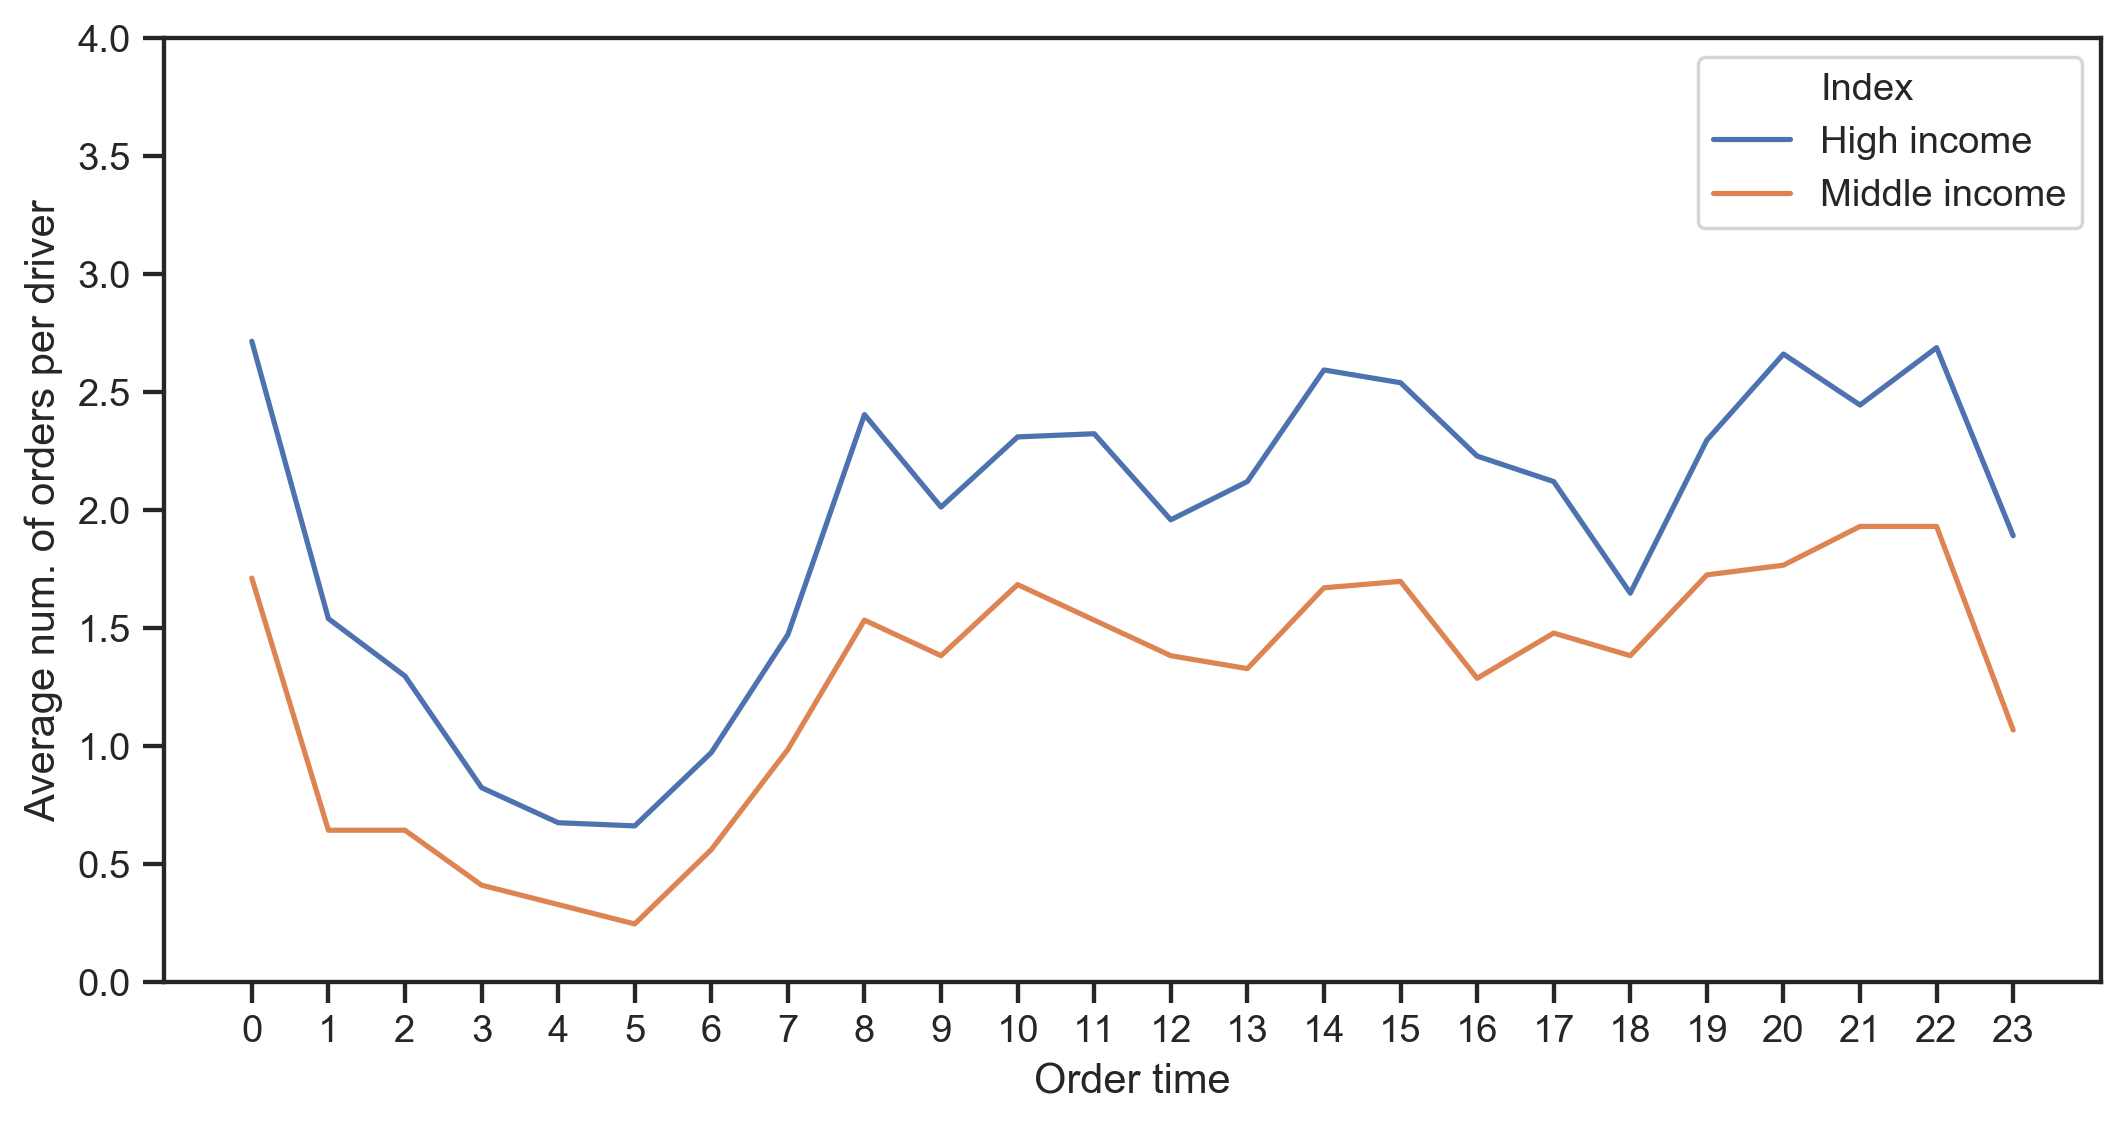

In [95]:

#统计高收入者和低收入者每小时平均的订单数量
high_hour =  (highincome_order.groupby(pd.to_datetime(highincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(highincome)).reset_index().rename(columns = {'price':'avg_count'})
high_hour['Index'] = 'High income'


mid_hour =  (midincome_order.groupby(pd.to_datetime(midincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(midincome)).reset_index().rename(columns = {'price':'avg_count'})
mid_hour['Index'] = 'Middle income'

#绘图
fig     = plt.figure(1,(10,5),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.lineplot(x="Stime", y="avg_count",hue="Index", data=pd.concat([high_hour,mid_hour]),ax = ax)
plt.ylabel('Average num. of orders per driver')
plt.xlabel('Order time')
plt.ylim(0,4)
plt.xticks(range(24),range(24))
plt.show()

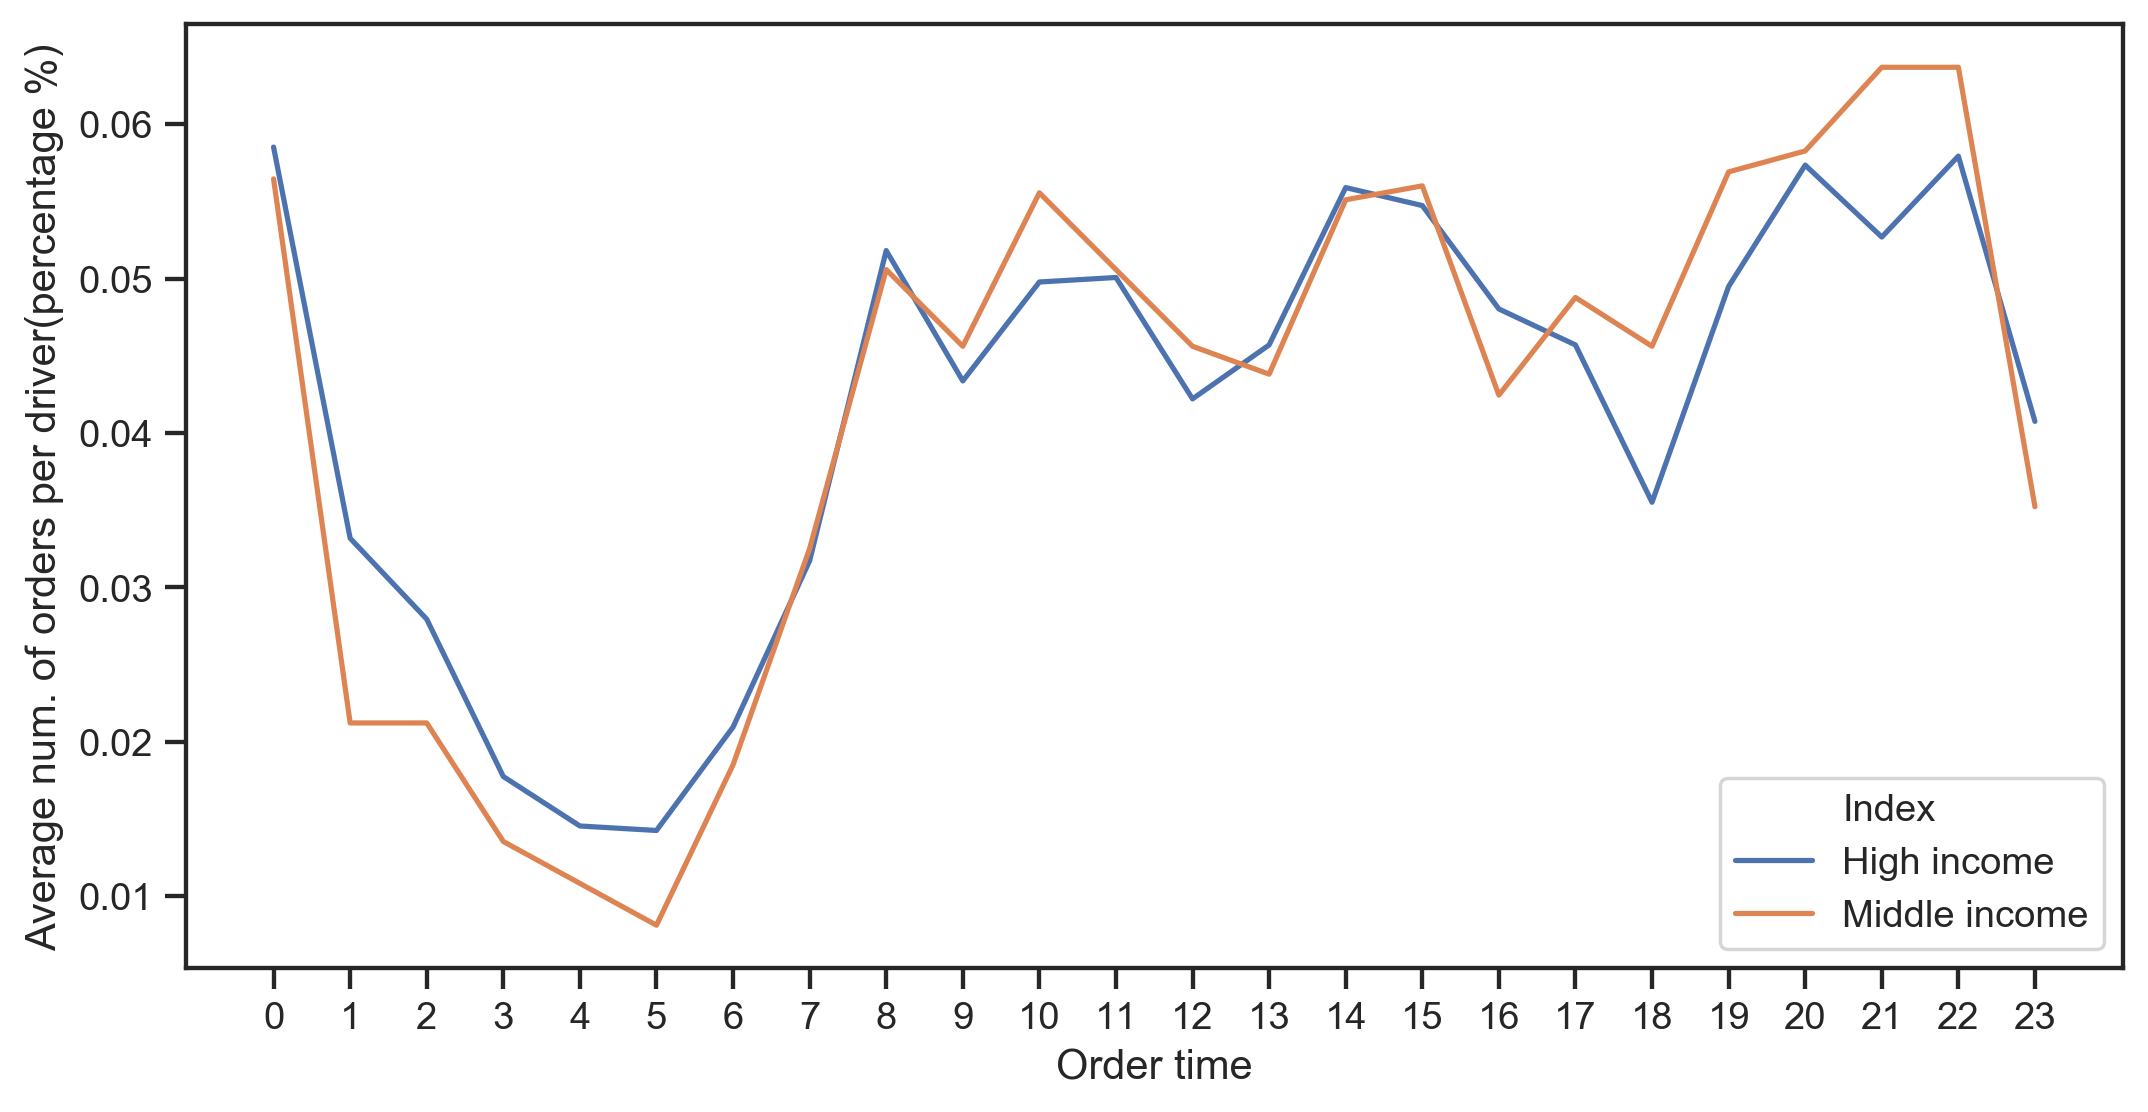

In [94]:

#统计高收入者和低收入者每小时平均的订单数量
high_hour =  (highincome_order.groupby(pd.to_datetime(highincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(highincome)).reset_index().rename(columns = {'price':'avg_count'})
high_hour['Index'] = 'High income'
high_hour['avg_count'] = high_hour['avg_count']/high_hour['avg_count'].sum()
mid_hour =  (midincome_order.groupby(pd.to_datetime(midincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(midincome)).reset_index().rename(columns = {'price':'avg_count'})
mid_hour['Index'] = 'Middle income'
mid_hour['avg_count'] = mid_hour['avg_count']/mid_hour['avg_count'].sum()
#绘图
fig     = plt.figure(1,(10,5),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.lineplot(x="Stime", y="avg_count",hue="Index", data=pd.concat([high_hour,mid_hour]),ax = ax)
plt.ylabel('Average num. of orders per driver(percentage %)')
plt.xlabel('Order time')
plt.xticks(range(24),range(24))
plt.show()

确实！高收入者比中收入者更倾向于在夜间活动！

统计高收入者和低收入者每小时订单的出行距离

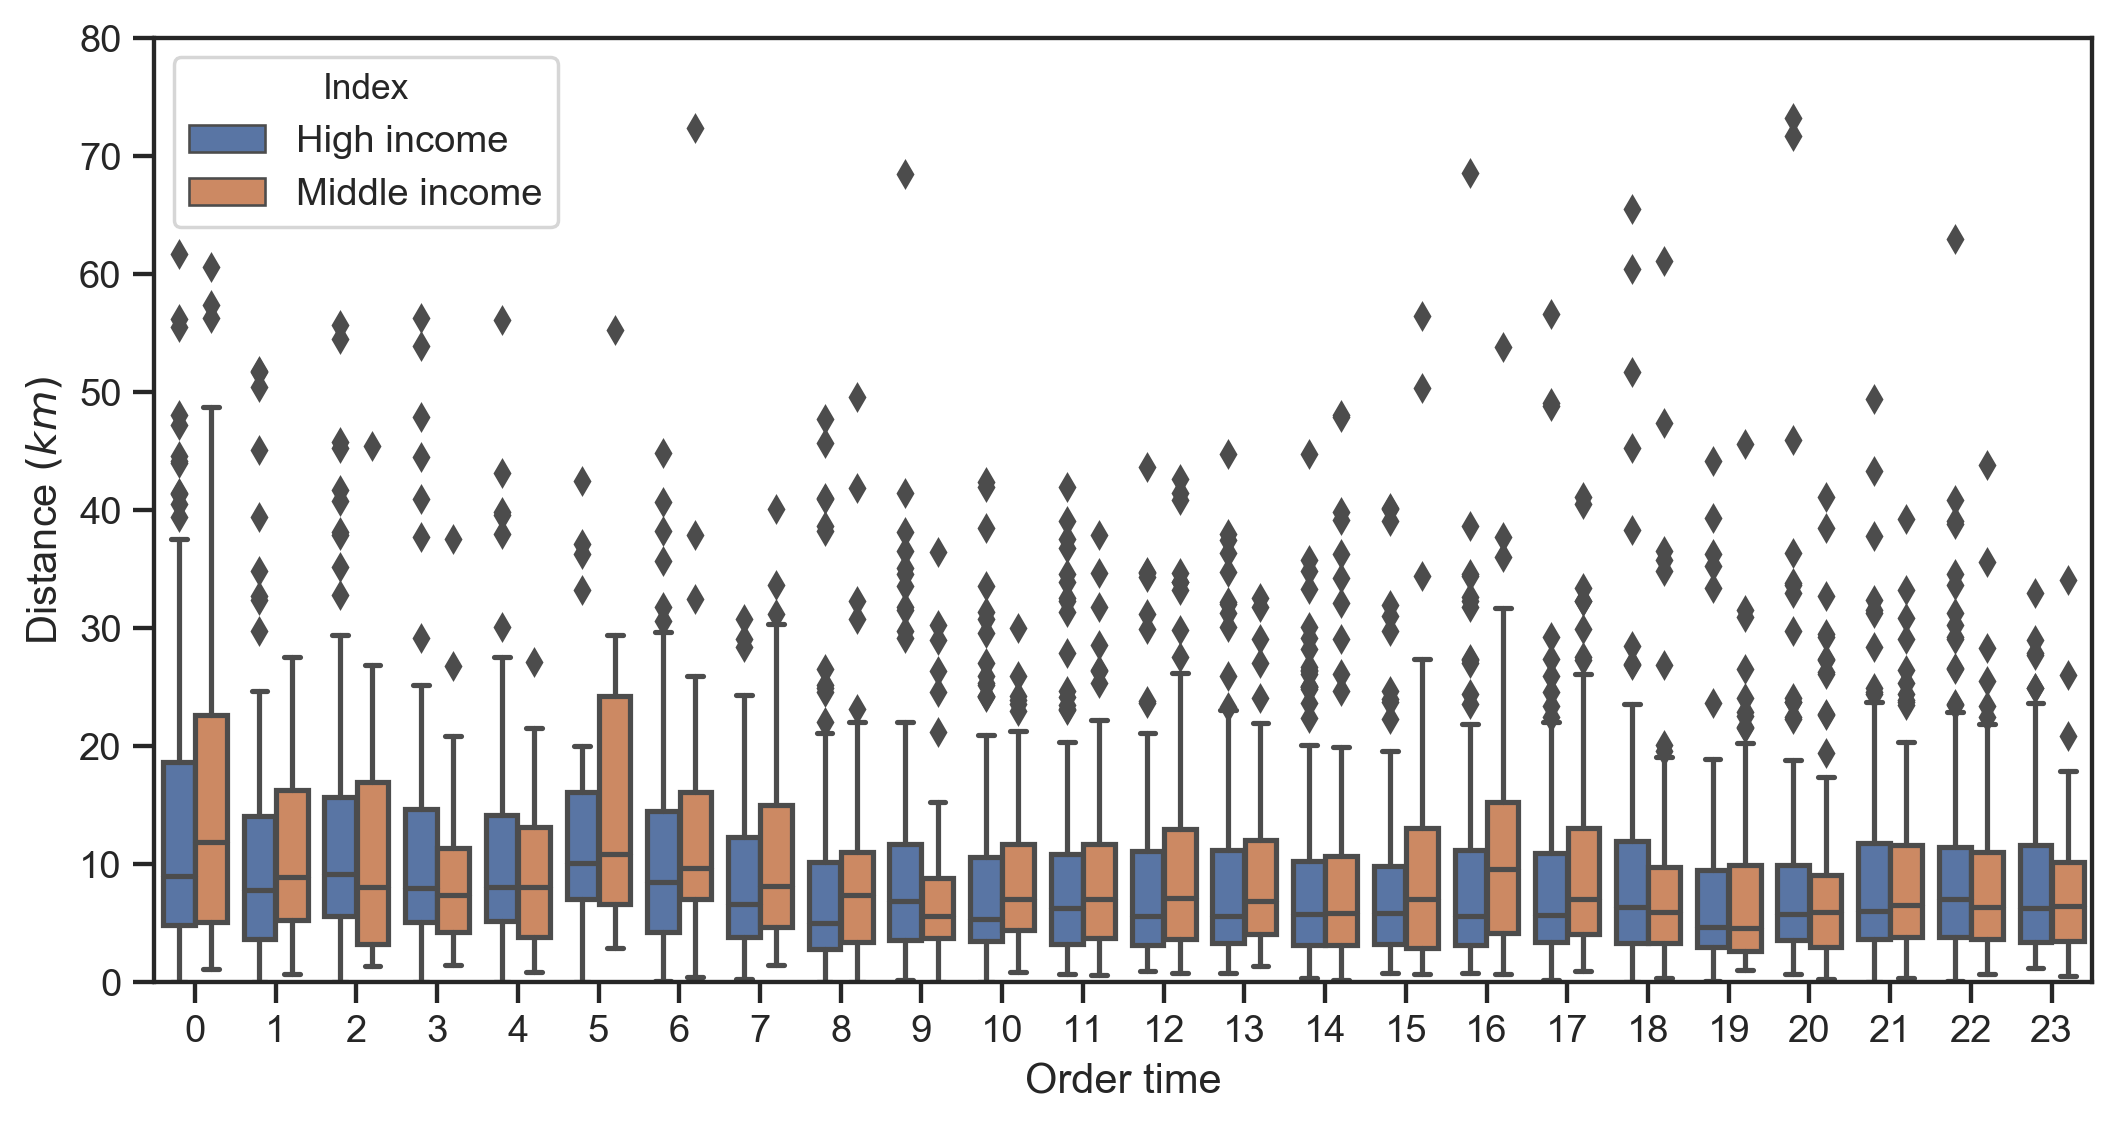

In [90]:

high_hour =  highincome_order[['Stime','distance']].copy()
high_hour['Shour'] = pd.to_datetime(highincome_order['Stime']).apply(lambda r:r.hour)
high_hour['Index'] = 'High income'
mid_hour =  midincome_order[['Stime','distance']].copy()
mid_hour['Shour'] = pd.to_datetime(midincome_order['Stime']).apply(lambda r:r.hour)
mid_hour['Index'] = 'Middle income'
hourdata = pd.concat([high_hour,mid_hour])
hourdata['distance'] = hourdata['distance']/1000

#绘图
fig     = plt.figure(1,(10,5),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="Shour", y="distance",hue="Index", data=hourdata,ax = ax)
plt.ylabel('Distance $(km)$')
plt.ylim(0,80)
plt.xlabel('Order time')
plt.show()

### 开车的秘诀总结

从上面的分析来看，高收入群体确实存在高收入的秘诀，总结一下，那就是：  

>1.勤奋，你需要比别人更勤奋，每天跑更多的路程，接更多的单  
2.选择性接单（拒载），你需要比别人接更多的短距离出行订单（高收入者接的订单平均出行距离比中收入者短！）  
3.工作时间，高收入者在夜间、凌晨的订单比例比中收入者更高，半夜开车挣钱多！